In [1]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

Using backend: pytorch


In [2]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


c:\users\nikhi\appdata\local\programs\python\python36\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


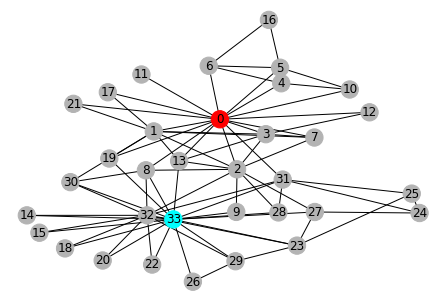

In [3]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
colours = [[.7, .7, .7] for i in range(34)]
colours[0] = [1,0,0]
colours[33] = [0,1,1]
nx.draw(nx_G, pos, with_labels=True, node_color=colours)




In [5]:
from dgl.nn.pytorch.conv import GraphConv
import torch.nn as nn
import torch.nn.functional as F


# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GraphConv(in_feats, hidden_size)
        self.gcn2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

In [7]:
import torch

inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
    


Epoch 0 | Loss: 0.6963
Epoch 1 | Loss: 0.6901
Epoch 2 | Loss: 0.6852
Epoch 3 | Loss: 0.6827
Epoch 4 | Loss: 0.6813
Epoch 5 | Loss: 0.6794
Epoch 6 | Loss: 0.6772
Epoch 7 | Loss: 0.6742
Epoch 8 | Loss: 0.6705
Epoch 9 | Loss: 0.6652
Epoch 10 | Loss: 0.6595
Epoch 11 | Loss: 0.6532
Epoch 12 | Loss: 0.6460
Epoch 13 | Loss: 0.6381
Epoch 14 | Loss: 0.6295
Epoch 15 | Loss: 0.6199
Epoch 16 | Loss: 0.6088
Epoch 17 | Loss: 0.5976
Epoch 18 | Loss: 0.5854
Epoch 19 | Loss: 0.5726
Epoch 20 | Loss: 0.5588
Epoch 21 | Loss: 0.5437
Epoch 22 | Loss: 0.5270
Epoch 23 | Loss: 0.5103
Epoch 24 | Loss: 0.4927
Epoch 25 | Loss: 0.4748
Epoch 26 | Loss: 0.4568
Epoch 27 | Loss: 0.4379
Epoch 28 | Loss: 0.4187
Epoch 29 | Loss: 0.3996
Epoch 30 | Loss: 0.3802
Epoch 31 | Loss: 0.3608
Epoch 32 | Loss: 0.3415
Epoch 33 | Loss: 0.3223
Epoch 34 | Loss: 0.3033
Epoch 35 | Loss: 0.2845
Epoch 36 | Loss: 0.2658
Epoch 37 | Loss: 0.2477
Epoch 38 | Loss: 0.2303
Epoch 39 | Loss: 0.2135
Epoch 40 | Loss: 0.1975
Epoch 41 | Loss: 0.1824
Ep

In [10]:
print(logits.shape)

torch.Size([34, 2])


<Figure size 432x288 with 0 Axes>

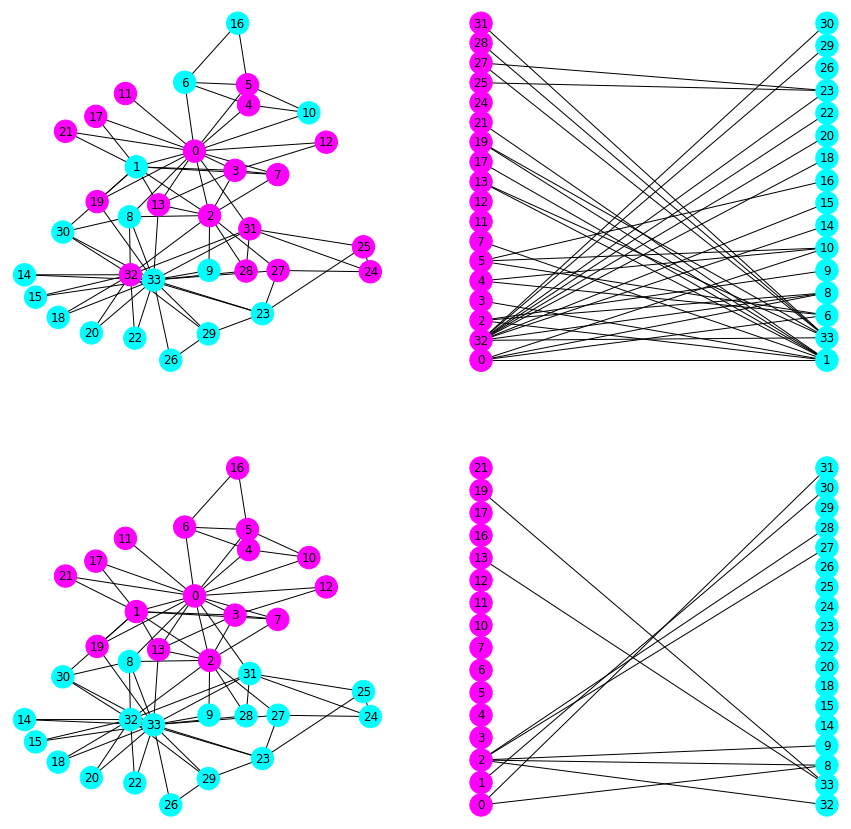

In [66]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(epoch,ax_x, ax_y):
    this_ax = ax[ax_x, ax_y]
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[epoch][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    this_ax.axis('off')
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=500, ax=this_ax)
        
def draw_bipartite(epoch,ax_x,ax_y):
    this_ax = ax[ax_x,ax_y]
    G = nx.Graph()
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    colors = []
    pos = {}
    for v in range(34):   
        pos[v] = all_logits[epoch][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
        G.add_node(v, bipartite = cls)
    this_ax.axis('off')
    top = [n for n in G.nodes if G.nodes[n]['bipartite'] == 0]
    pos = nx.bipartite_layout(G, top)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=500, ax=this_ax)
    




In [ ]:
all_logits[0].shape

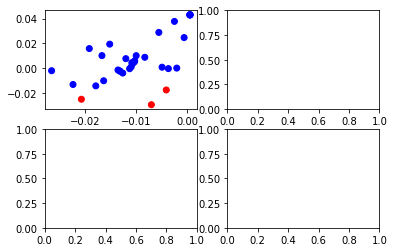

In [82]:
c1 = (1,0,0)
c2 = (0,0,1)

def plot_logits(epoch, ax_x,ax_y):
    this_ax = ax[ax_x,ax_y]
    data = all_logits[epoch]
    xs = data[:, 0].tolist()
    ys = data[:, 1].tolist()
    labels = []
    for x,y in data:
        if x > y:
            labels.append(c1)
        else:
            labels.append(c2)
            

        
    
    this_ax.scatter(xs,ys, c=labels)
    
fig, ax = plt.subplots(2, 2)

plot_logits(0, 0,0)

In [ ]:
fig = plt.figure(1); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(20,15))

draw(1,0,0)  # draw the prediction of the first epoch
draw(-1,1,0)
draw_bipartite(1,0,1)
draw_bipartite(-1,1,1)
plot_logits(1,0,2)
plot_logits(-1,1,2)


plt.show()

<Figure size 432x288 with 0 Axes>

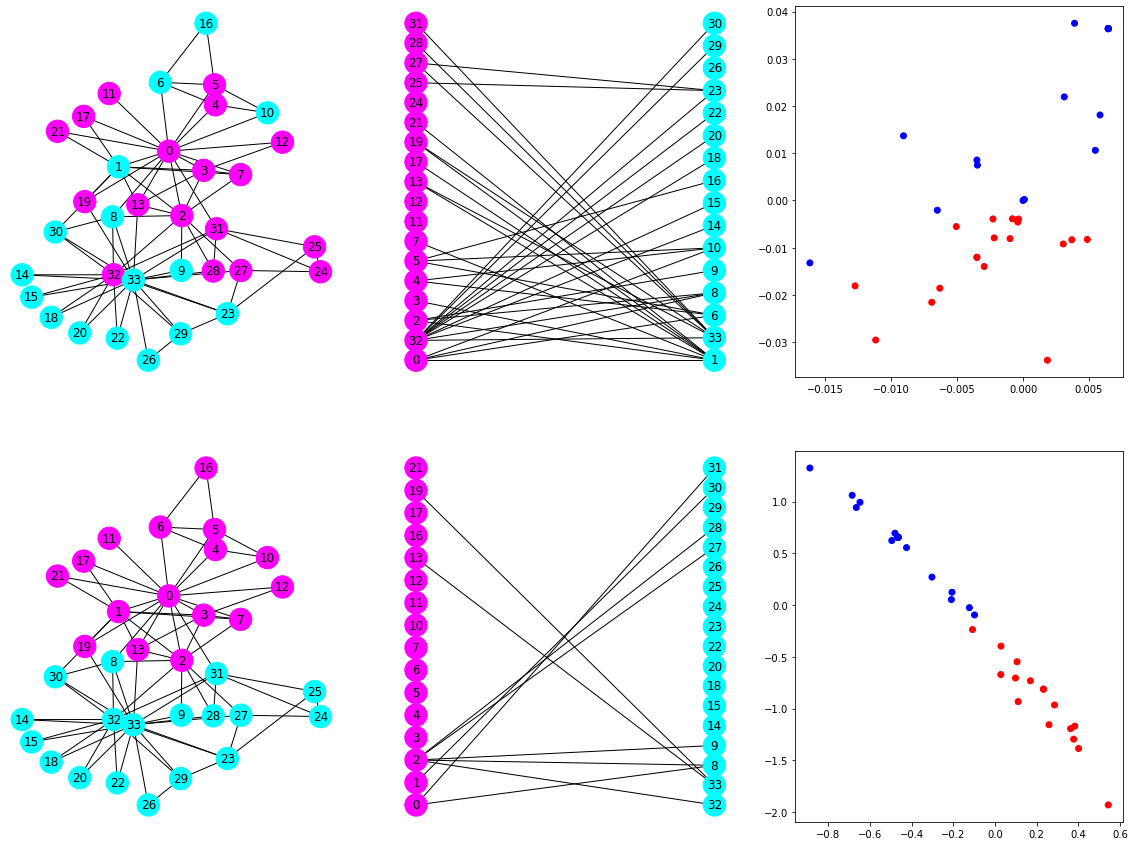

In [84]:
fig = plt.figure(1); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(20,15))

draw(1,0,0)  # draw the prediction of the first epoch
draw(-1,1,0)
draw_bipartite(1,0,1)
draw_bipartite(-1,1,1)
plot_logits(1,0,2)
plot_logits(-1,1,2)


plt.show()